In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
import librosa 
from librosa.display import specshow
import tqdm 
import scipy
from copy import deepcopy
import sklearn
import skimage.io as io
%matplotlib inline

In [2]:
os.path.expanduser('~/Users/phinchosherpa/Desktop/nyu/BirdVox-15min/unit01_10-08-45.wav')
wav_path='/Users/phinchosherpa/Desktop/nyu/BirdVox-15min/unit01_10-08-45.wav'

In [3]:
def acoustic_features(wav_path, verbose=False):
    hop_length = 32
    n_fft = 256
    chunk_duration = 10 # in seconds
    y, sr = librosa.load(wav_path)
    chunk_length = chunk_duration * sr
    chunk_hop_length = int(chunk_length * 0.5)
    y_chunks = librosa.util.frame(
        y, frame_length=chunk_length, hop_length=chunk_hop_length)
    n_chunks = y_chunks.shape[1]
    
    fft_frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    fmin = 1000 # in Hertz
    fmax = 10000 # in Hertz
    bin_start = np.where(fft_frequencies>=fmin)[0][0]
    bin_stop = np.where(fft_frequencies<fmax)[0][-1]
    n_bins = bin_stop - bin_start
    
    X_dict = {
        "average_energy": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "maximum_energy": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "maximum_spectral-flux": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "acoustic-complexity-index": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "negative-entropy": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "maximum_weighted-phase-deviation": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "maximum_pcen-flux_longdistance": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "maximum_pcen-flux_birdvoxdetect": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "maximum_pcen_longdistance": np.full((n_bins, n_chunks), np.float64(np.nan)),
        "maximum_pcen_birdvoxdetect": np.full((n_bins, n_chunks), np.float64(np.nan))
    }
    for chunk_id in tqdm.tqdm(range(n_chunks), disable=(not verbose)):
        # Compute Instantaneous frequency spectrogram (ifgram) and
        # Short-Term Fourier Transform (STFT).
        y_chunk = y_chunks[:, chunk_id]
        ifgram, stft = librosa.ifgram(
            y_chunk, n_fft=n_fft, hop_length=hop_length, ref_power=1e-6)
        
        # Restrict to 1kHz - 10kHz frequency range.
        ifgram = ifgram[bin_start:bin_stop, :]
        stft = stft[bin_start:bin_stop, :]
        # Compute STFT magnitude
        spectrogram = np.abs(stft)**2
        # Compute average and maximum energy
        avg_energy = np.mean(spectrogram, axis=1)
        X_dict["average_energy"][:, chunk_id] =\
            avg_energy
        X_dict["maximum_energy"][:, chunk_id] =\
            np.max(spectrogram, axis=1)
        # Compute acoustic complexity index (ACI).
        total_variation = np.abs(np.diff(spectrogram, axis=1))
        X_dict["acoustic-complexity-index"][:, chunk_id] =\
            np.mean(total_variation, axis=1) / avg_energy
        # Compute maximum spectral flux.
        X_dict["maximum_spectral-flux"][:, chunk_id] =\
            np.max(total_variation, axis=1)
        # Compute negative entropy. (the greater, the sparser)
        X_dict["negative-entropy"][:, chunk_id] =\
            np.array([-scipy.stats.entropy(row**2) for row in spectrogram])
        # Compute maximum weighted phase deviation
        X_dict["maximum_weighted-phase-deviation"][:, chunk_id] = np.max(
            spectrogram[:, :-1] * np.abs(np.diff(ifgram, axis=1)), axis=1)
        # Compute max PCEN (DCASE-style)
        spectrogram_bis = np.concatenate((spectrogram[:, ::-1], spectrogram), axis=1)
        pcen_dcase_bis = librosa.pcen(
            spectrogram_bis*(2**16), hop_length=hop_length,
            gain=1.0, bias=0.0, power=0.0, time_constant=0.1)
        X_dict["maximum_pcen-flux_longdistance"][:, chunk_id] = np.max(np.abs(np.diff(
            pcen_dcase_bis[:, stft.shape[1]:], axis=1)), axis=1)
        X_dict["maximum_pcen_longdistance"][:, chunk_id] = np.max(
            pcen_dcase_bis[:, stft.shape[1]:], axis=1)
        # Compute max PCEN (BirdVoxDetect-style)
        pcen_bvd_bis = librosa.pcen(
            spectrogram_bis*(2**16), hop_length=hop_length,
            gain=0.8, bias=10.0, power=0.25, time_constant=0.06)
        X_dict["maximum_pcen-flux_birdvoxdetect"][:, chunk_id] = np.max(
            pcen_bvd_bis[:, stft.shape[1]:], axis=1)
        X_dict["maximum_pcen_birdvoxdetect"][:, chunk_id] = np.max(
            np.abs(np.diff(pcen_bvd_bis[:, stft.shape[1]:], axis=1)), axis=1)
    # Apply global Box-Cos transformation 
    epsilon = np.finfo(np.float32).eps
    for k in X_dict:
        x_ravel = X_dict[k].ravel()
        if np.all(x_ravel<0):
            x_ravel = -x_ravel
        x_ravel_eps = x_ravel + epsilon
        x_ravel_bc, _ = scipy.stats.boxcox(x_ravel_eps)
        x_bc = np.reshape(x_ravel_bc, X_dict[k].shape)
        if np.all(x_ravel<0):
            x_bc = -x_bc
        X_dict[k] = sklearn.preprocessing.MinMaxScaler(
            feature_range=(0.001, 0.999)).fit_transform(x_bc)
        
    return X_dict

In [17]:
os.listdir('/Users/phinchosherpa/Desktop/nyu/BirdVox-15min/')

['unit07_00-23-50.wav',
 'unit01_10-08-45.wav',
 'unit10_00-00-50.wav',
 'unit02_00-00-30.wav',
 'unit05_03-48-40.wav',
 'unit05_09-54-10.wav',
 'unit10_07-54-24.wav',
 'unit01_10-41-15.wav',
 'unit02_00-23-30.wav',
 'unit10_01-01-25.wav',
 'unit01_10-31-25.wav',
 'unit03_00-19-45.wav',
 'unit07_00-11-00.wav',
 'unit03_10-34-20.wav',
 'unit10_00-22-10.wav']

In [19]:
wav_path='/Users/phinchosherpa/Desktop/nyu/BirdVox-15min/unit10_07-54-24.wav'

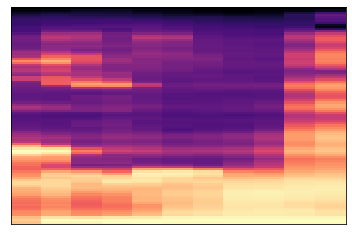

In [21]:

X_dict = acoustic_features(wav_path)
feature_strs = ['average_energy',
 'maximum_energy',
 'maximum_spectral-flux',
 'acoustic-complexity-index',
 'negative-entropy',
 'maximum_weighted-phase-deviation',
 'maximum_pcen-flux_longdistance',
 'maximum_pcen-flux_birdvoxdetect',
 'maximum_pcen_longdistance',
 'maximum_pcen_birdvoxdetect']


#specshow(X_dict["average_energy"], cmap='gray_r')
specshow(X_dict["maximum_spectral-flux"], cmap='magma')
specshow(X_dict["average_energy"], cmap='magma')

<Figure size 1080x1080 with 0 Axes>

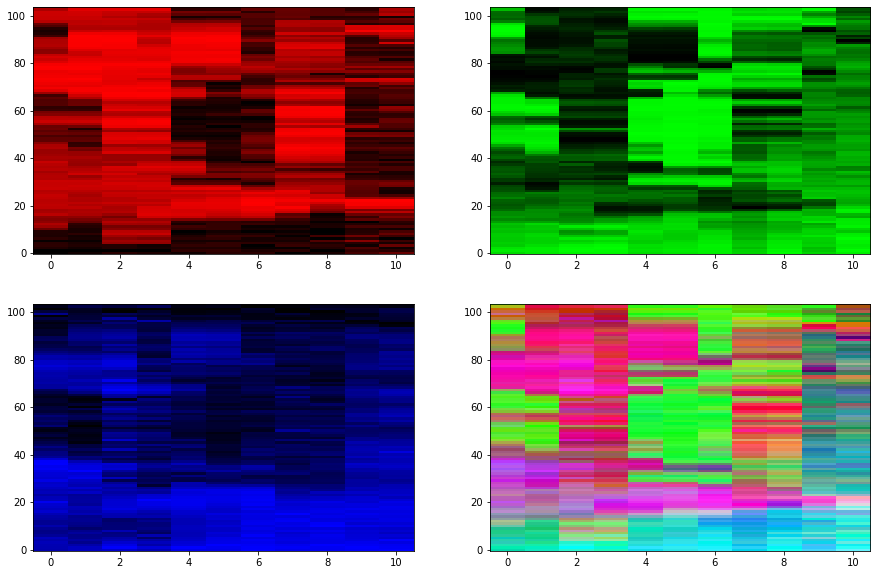

In [26]:
RGB = np.stack((
    X_dict['maximum_pcen_longdistance'],
    X_dict["negative-entropy"],
    X_dict["maximum_weighted-phase-deviation"]
), axis=-1);

R = deepcopy(RGB)[:, :];
R[:, :, 1] = 0;
R[:, :, 2] = 0;

G = deepcopy(RGB);
G[:, :, 0] = 0;
G[:, :, 2] = 0;

B = deepcopy(RGB);
B[:, :, 0] = 0;
B[:, :, 1] = 0;

W= R+G+B

plt.figure(figsize=(15, 15))
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

ax[0,0].imshow(R, aspect="auto", origin="lower")
ax[0,1].imshow(G, aspect="auto", origin="lower")
ax[1,0].imshow(B, aspect="auto", origin="lower")
ax[1,1].imshow(W, aspect="auto", origin="lower")

0.9990000000000023